In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(888)

In [2]:
# Для отключения GPU в TensorFlow

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

In [3]:
dataset = pd.read_csv("train.csv")
dataset.head(8)

,id,name,tare
0,0,Котлеты МЛМ из говядины 335г,коробка
1,1,Победа Вкуса конфеты Мишки в лесу 250г(КФ ПОБЕ...,коробка
2,2,"ТВОРОГ (ЮНИМИЛК) ""ПРОСТОКВАШИНО"" ЗЕРНЕНЫЙ 130Г...",стаканчик
3,3,Сыр Плавленый Веселый Молочник с Грибами 190г ...,контейнер
4,4,Жевательный мармелад Маша и медведь буквы 100г,пакет без формы
5,5,Напиток Lipton черный чай б/алк персик 2л пэт,бутылка
6,6,Сыр VALIO ГОЛЛАНДСКИЙ 140г 45% нарезка,лоток
7,7,"Вино Вилла Феличи бел п/сл 10-12 % 0,75л",бутылка


In [4]:
len(dataset)

40648

**Распределение категорий:**

In [4]:
dataset["tare"].value_counts()

пакет без формы                   9028
бутылка                           7474
коробка                           4196
пакет прямоугольный               3501
обертка                           3217
банка неметаллическая             2238
стаканчик                         2070
банка металлическая               1837
вакуумная упаковка                1071
усадочная упаковка                 993
контейнер                          884
пачка                              691
лоток                              628
туба                               589
гофрокороб                         419
колбасная оболочка                 396
тортница                           324
без упаковки                       322
упаковка с газовым наполнением     289
ведро                              253
ячеистая упаковка                  228
Name: tare, dtype: int64

Видим, что распределение неравномерное

## Препроцессинг данных

#### 1) Обработка текста регулярными выражениями

##### Что бросается в глаза в самих названиях:

1. Присутствие как точек так и запятых в качестве разделителей для вещественных чисел (**12.5** vs **12,5**)
2. Различные форматы для веса, объема, процентов:
    * **0.5кг**, **0.5 кг**, **500г**, **500 г**, **500гр**, **500 гр**
    * **0.5л**, **0.5 л**, **500мл**, **500 мл**
    * **0.5%**, **0.5 %**
3. Обратный слэш "**\\**" вместо прямого: **ж\б** vs **ж/б**
4. **ЗефирДляДесертов125г** - camelCase вместо пробелов (стандартный tokenizer воспринимает это как один токен)
5. **1.8\*20** vs **1.8х20** (русская "**х**") vs **1.8x20** (латинская "**x**")

In [5]:
import re

# переходы "aA", "Aa" (но не в начале слова), "a9", "A9", "9a", "9A"
camel_case_re = re.compile(r"((?<=[а-я])[А-Я]|(?<!\b)[А-Я](?=[а-я])|(?<=[А-Яа-я])[0-9]|(?<=[0-9])[А-Яа-я])")

# русская и латинская "x" между числами
times_re = re.compile(r"(?<=[0-9])[хХxX](?=[0-9])")

# string.punctuation без [.,%] но с [«»]
redundant_punctuation_re = re.compile(r'[!"#$&\'()*+\-/:;<=>?@\[\\\]^_`{|}~«»]')

# Для различных форматов веса, объема и процентов
weight_re = re.compile(r"(?P<number>[0-9]+([.][0-9]+)?)[ ]*(?P<units>(гр?|кг))")
volume_re = re.compile(r"(?P<number>[0-9]+([.][0-9]+)?)[ ]*(?P<units>(м?л))")
percent_re = re.compile(r"(?P<number>[0-9]+([.][0-9]+)?)[ ]*(?P<units>(%))")

dots_but_not_inside_numbers_re = re.compile(r"(?<![0-9])\.|\.(?![0-9])")

redundant_slashes_re = re.compile(r"(?<= )/|(?<=\A)/|/(?= )|/(?=\Z)")


# "0.5кг", "0.5 кг", "500г", "500 г", "500гр", "500 гр" -> " 500 гр "
def format_weight_value(match_object):
    number = float(match_object.group("number"))
    units = match_object.group("units")

    if units == "кг":
        number *= 1000

    number = int(round(number))
    return " " + str(number) + " гр "


# "0.5л", "0.5 л", "500мл", "500 мл" -> " 0.5 л "
def format_volume_value(match_object):
    number = float(match_object.group("number"))
    units = match_object.group("units")

    if units == "мл":
        number /= 1000
    return " " + str(number).rstrip('0').rstrip('.') + " л "


# "0.5%", "0.5 %" -> " 0.5 % "
def format_percent_value(match_object):
    number = float(match_object.group("number"))
    return " " + str(number).rstrip('0').rstrip('.') + " % "



def cleanse_product_name(name: str):
    name = name.replace("ё", "е")
    name = name.replace("Ё", "Е")

    # "1.8x20" -> "1.8*20"
    name = re.sub(times_re, "*", name)

    # Заменить camelCase на разделение пробелами
    # Example: "ЗефирДляДесертов125г" -> "Зефир Для Десертов 125 г"
    name = re.sub(camel_case_re, r' \1', name)

    # Теперь у заглавных букв нет пользы
    name = name.lower()

    # Убрать пунктуацию кроме . , %
    name = re.sub(redundant_punctuation_re, " ", name)

    # Чтобы не возиться с запятыми в вещественных числах
    name = name.replace(",", ".")

    name = re.sub(weight_re, format_weight_value, name)
    name = re.sub(volume_re, format_volume_value, name)
    name = re.sub(percent_re, format_percent_value, name)

    # удалить "." если не внутри вещественного числа
    name = re.sub(dots_but_not_inside_numbers_re, " ", name)

    return name

#### 2) Стэмминг

In [6]:
from nltk.stem.snowball import RussianStemmer

stemmer = RussianStemmer()

def stem_all_words(name: str):
    return " ".join([stemmer.stem(token) for token in name.split()])

### Финальная функция препроцессинга

In [7]:
def preprocess(dataframe):
    return dataframe.apply(cleanse_product_name).apply(stem_all_words)

# Подготовка данных для обучения

Для работы нейронной сети нужно преобразовать текст и категории в **векторное представление**

### Для наименований продуктов:

Препроцессинг

In [8]:
dataset_names_preprocessed = preprocess(dataset['name'])

Создадим частотный словарь всех слов в данных для обучения (будем учитывать топ-4000 слова)

In [9]:
from keras.preprocessing.text import Tokenizer

max_words = 4000
tokenizer = Tokenizer(max_words)
tokenizer.fit_on_texts(dataset_names_preprocessed)

Using TensorFlow backend.


Преобразуем данные для обучения в векторное представление и приведём к одной длине

In [10]:
from keras.preprocessing import sequence

def to_vector(dataframe):
    return sequence.pad_sequences(tokenizer.texts_to_sequences(dataframe), maxlen=15)

In [11]:
dataset_x = to_vector(dataset_names_preprocessed)

### Для категорий:

Каждой категории сопоставляется натуральное число

In [12]:
categories_ammount = dataset["tare"].nunique()

print(f'Количество категорий - {categories_ammount}')

Количество категорий - 21


In [13]:
# массив n-мерных векторов, где n - количество категорий
onehot = pd.get_dummies(dataset['tare'])

# массив категорий
categories = onehot.columns

In [14]:
dataset_y = np.argmax(onehot.values, axis=1)

### Разделение на данные для обучения и тестовые данные

Так как отдельно тестовые данные не присутствуют, возьмём 20% от всех данных и будем использовать в качестве тестовых

Следует так же отметить, что категории распределены неравномерно, но нам нужны "хорошие" данные для тестирования (в которых категории распределены пропорционально), поэтому используем **stratify** в **train_test_split**

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.2, random_state=888, stratify=dataset_y)

# Нейронная сеть с долго-краткосрочной памятью

Состоит из трёх слоёв

1) **Embedding** - входной слой для векторного представления текста, в котором 4000 слов представлены векторами из 32 чисел

2) **LSTM** - слой с долго-краткосрочной памятью, в котором 100 элементов для хранения данных

3) **Dense** - полносвязный слой, используемый для классификации, с функцией активации softmax 

In [16]:
from keras.models import Sequential
from keras.layers import *

model = Sequential()
model.add(Embedding(max_words, 32, input_length=15))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(categories_ammount, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Обучение нейронной сети

Используем 20% train data для валидации

In [17]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Train on 26014 samples, validate on 6504 samples
Epoch 1/10
26014/26014 [==============================] - 11s 417us/step - loss: 2.0833 - acc: 0.3293 - val_loss: 1.3995 - val_acc: 0.5666
Epoch 2/10
26014/26014 [==============================] - 10s 373us/step - loss: 1.1735 - acc: 0.6548 - val_loss: 1.0054 - val_acc: 0.7069
Epoch 3/10
26014/26014 [==============================] - 10s 375us/step - loss: 0.8678 - acc: 0.7449 - val_loss: 0.8157 - val_acc: 0.7654
Epoch 4/10
26014/26014 [==============================] - 10s 375us/step - loss: 0.7077 - acc: 0.7961 - val_loss: 0.7440 - val_acc: 0.7852
Epoch 5/10
26014/26014 [==============================] - 10s 373us/step - loss: 0.5982 - acc: 0.8281 - val_loss: 0.6946 - val_acc: 0.8069
Epoch 6/10
26014/26014 [==============================] - 10s 375us/step - loss: 0.5253 - acc: 0.8466 - val_loss: 0.6731 - val_acc: 0.8098
Epoch 7/10
26014/26014 [==============================] - 10s 373us/step - loss: 0.4704 - acc: 0.8621 - val_loss: 0.6

Дальнейшие наблюдения показывают, что после 10-12 эпохи прироста точности практически нет, а **val_loss** возрастает => нейронная сеть начинает переобучаться

Для различных значений **max_words** и **input_length** максимальная точность держится в районе 80% процентов

Поэтому остановимся на 10й эпохе при **max_words** = 4000 и **input_length** = 15

## Проверка на тестовых данных

In [18]:
scores = model.evaluate(X_test, y_test, batch_size=64)
print("Точность на тестовых данных: %.2f%%" % (scores[1] * 100))

8130/8130 [==============================] - 0s 59us/step
Точность на тестовых данных: 82.00%


### Более подробно

Для каждого типа упаковки выведем наиболее популярные предсказания (>=10% случаев)

In [19]:
rounded_predictions = model.predict_classes(X_test, batch_size=64)

#### Матрица ошибок

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=rounded_predictions)

Код для отрисовки матрицы, взятый из примеров модуля sklearn

In [21]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


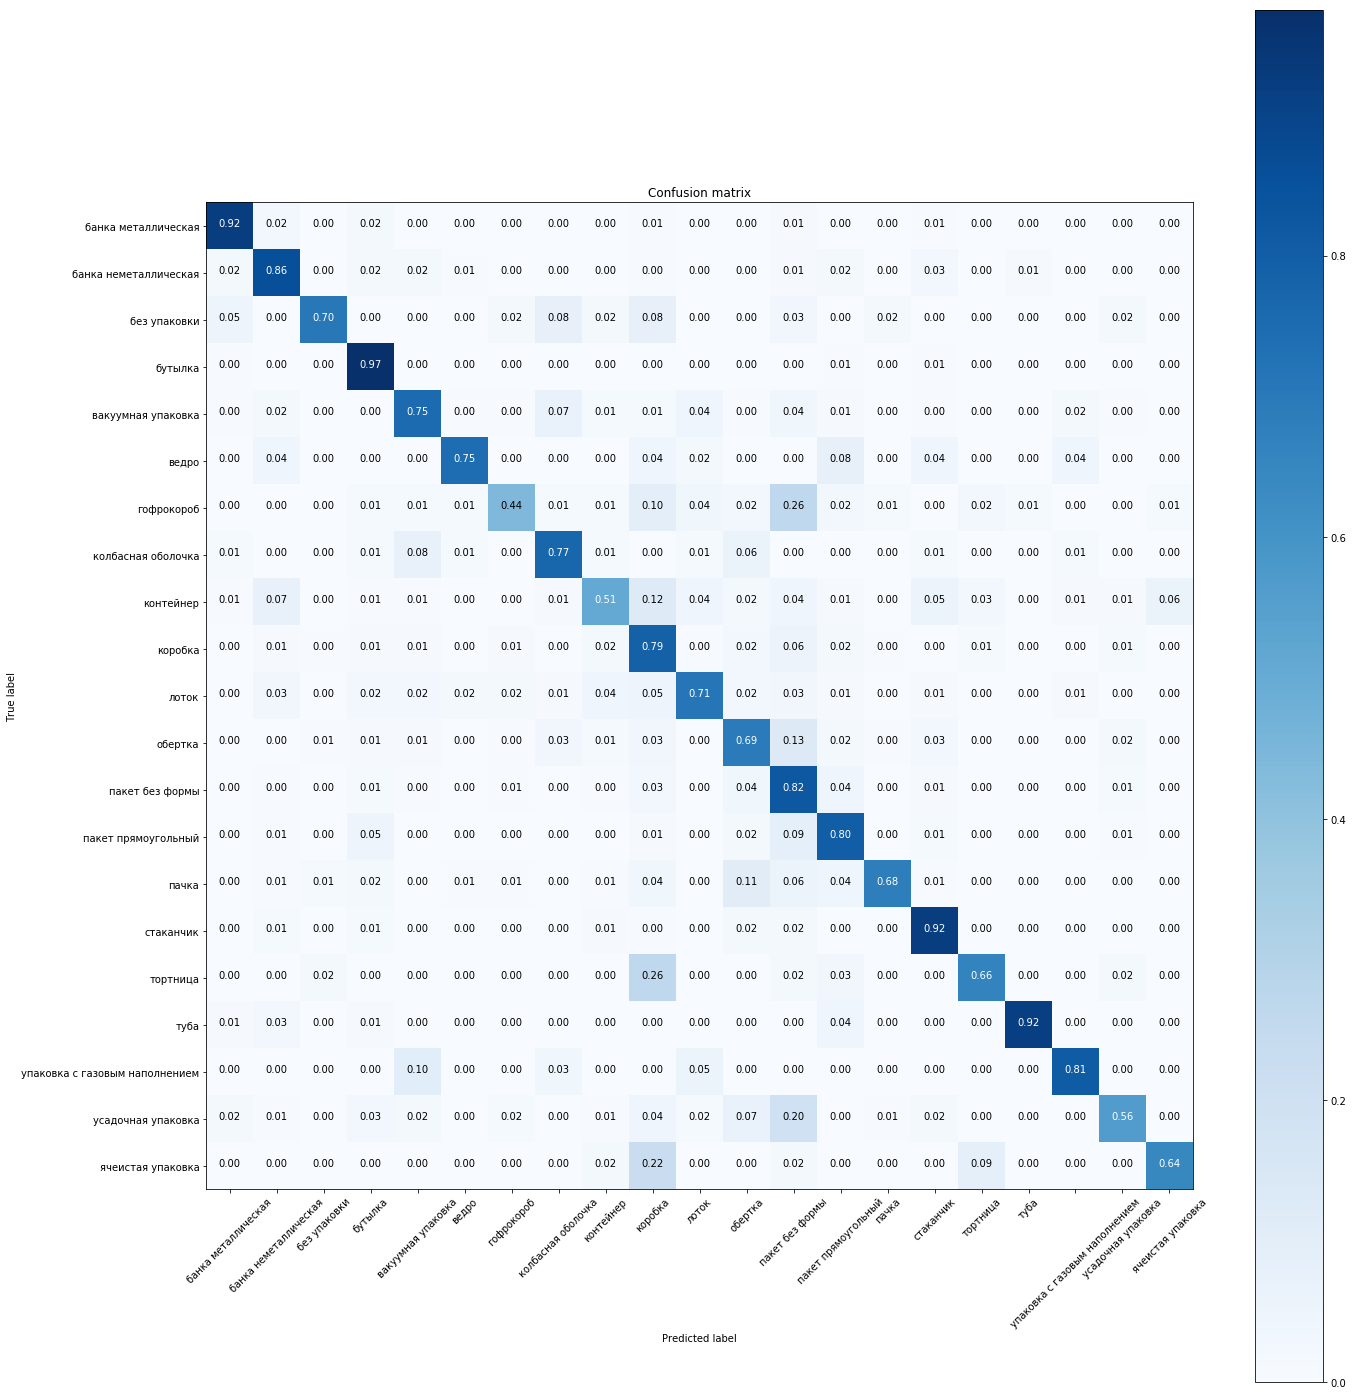

In [22]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, categories, True)
plt.show()

In [23]:
from collections import Counter

test_classes_counts = Counter(y_test)
total_classes = len(test_classes_counts)

In [24]:
for true_class_id in range(total_classes):
    true_class_name = categories[true_class_id]
    true_class_count = test_classes_counts[true_class_id]
    print('Для настоящей упаковки "{0}" ({1} тестовых экземпляров) были предложены:'.format(true_class_name, true_class_count))
    
    for pred_class_id in range(total_classes):
        percent = cm[true_class_id, pred_class_id] / true_class_count * 100
        if percent >= 10:
            pred_class_name = categories[pred_class_id]
            print('\t"{0}" в {1:.2f} % случаев ({2} раз)'.format(pred_class_name, percent, cm[true_class_id, pred_class_id]))
    
    print()

Для настоящей упаковки "банка металлическая" (367 тестовых экземпляров) были предложены:
	"банка металлическая" в 91.83 % случаев (337 раз)

Для настоящей упаковки "банка неметаллическая" (448 тестовых экземпляров) были предложены:
	"банка неметаллическая" в 85.71 % случаев (384 раз)

Для настоящей упаковки "без упаковки" (64 тестовых экземпляров) были предложены:
	"без упаковки" в 70.31 % случаев (45 раз)

Для настоящей упаковки "бутылка" (1495 тестовых экземпляров) были предложены:
	"бутылка" в 97.46 % случаев (1457 раз)

Для настоящей упаковки "вакуумная упаковка" (214 тестовых экземпляров) были предложены:
	"вакуумная упаковка" в 75.23 % случаев (161 раз)

Для настоящей упаковки "ведро" (51 тестовых экземпляров) были предложены:
	"ведро" в 74.51 % случаев (38 раз)

Для настоящей упаковки "гофрокороб" (84 тестовых экземпляров) были предложены:
	"гофрокороб" в 44.05 % случаев (37 раз)
	"пакет без формы" в 26.19 % случаев (22 раз)

Для настоящей упаковки "колбасная оболочка" (79 тесто